# Classification Origin

Papers:

https://www.semanticscholar.org/paper/Music-and-Geography%3A-Content-Description-of-Musical-G%C3%B3mez-Haro/4d48f2eaefc6a8336149e4cca1c5d2264969f223#paper-topics



In [211]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import the colormap module
import folium
from scipy.spatial import Voronoi
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing



In [212]:
music_origin_data = pd.read_csv('./data/kaggle/Music_origin.csv')
music_origin_cr_data = pd.read_csv('./data/kaggle/Music_origin_chromatic.csv')
gdf_bondaries = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

music_origin_data.drop('Unnamed: 0',axis=1,inplace=True)
music_origin_cr_data.drop('Unnamed: 0',axis=1,inplace=True)

C:\Users\claud\AppData\Local\Temp\ipykernel_20656\229727454.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


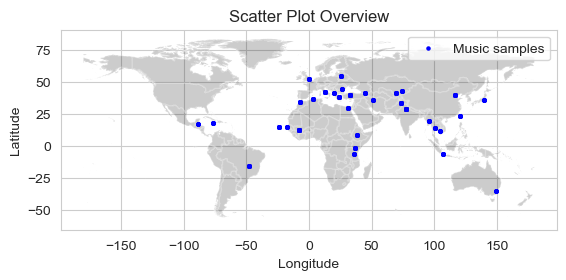

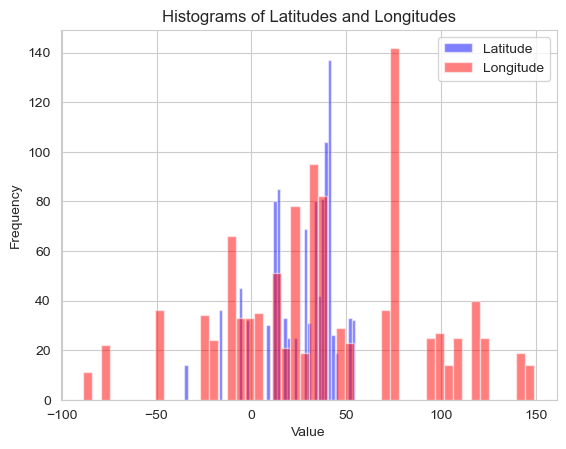

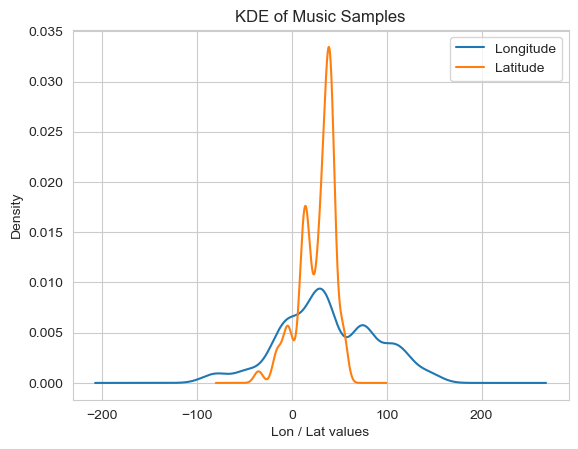

In [213]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))




gdf_bondaries.plot(ax=plt.gca(), color='black', alpha=0.2, label='Shapefile')
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot Overview')
plt.legend()
plt.show()


plt.hist(music_origin_data["Latitude"], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(music_origin_data["Longitude"], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.show()



music_origin_data[["Longitude","Latitude"]].plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.show()

In [214]:
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster


geometry = [Point(xy) for xy in zip(music_origin_data['Longitude'], music_origin_data['Latitude'])]
music_origin_gdf = gpd.GeoDataFrame(music_origin_data, geometry=geometry, crs="EPSG:4326")

music_origin_gdf = gpd.sjoin(music_origin_gdf, gdf_bondaries, how="left", op="within")

# Identify points that did not match
unmatched_points = music_origin_gdf[music_origin_gdf['index_right'].isna()].copy()

# For each unmatched point, find the nearest polygon and assign its attributes
for idx, point in unmatched_points.iterrows():
    point_geom = point['geometry']
    nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
    nearest_polygon_attributes = gdf_bondaries.loc[nearest_polygon_idx]
    music_origin_gdf.loc[idx, music_origin_gdf.columns.intersection(nearest_polygon_attributes.index)] = nearest_polygon_attributes

# Clean up the result DataFrame (remove unnecessary columns)
music_origin_gdf = music_origin_gdf.drop(columns=['index_right']).rename(columns={'index_left': 'original_index'})
music_origin_gdf.columns

C:\ProgramData\Anaconda3\envs\Zonal_Generatuor_new\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\claud\AppData\Local\Temp\ipykernel_20656\3381158856.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()


Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8', 'Feature9', 'Feature10', 'Feature11',
       'Feature12', 'Feature13', 'Feature14', 'Feature15', 'Feature16',
       'Feature17', 'Feature18', 'Feature19', 'Feature20', 'Feature21',
       'Feature22', 'Feature23', 'Feature24', 'Feature25', 'Feature26',
       'Feature27', 'Feature28', 'Feature29', 'Feature30', 'Feature31',
       'Feature32', 'Feature33', 'Feature34', 'Feature35', 'Feature36',
       'Feature37', 'Feature38', 'Feature39', 'Feature40', 'Feature41',
       'Feature42', 'Feature43', 'Feature44', 'Feature45', 'Feature46',
       'Feature47', 'Feature48', 'Feature49', 'Feature50', 'Feature51',
       'Feature52', 'Feature53', 'Feature54', 'Feature55', 'Feature56',
       'Feature57', 'Feature58', 'Feature59', 'Feature60', 'Feature61',
       'Feature62', 'Feature63', 'Feature64', 'Feature65', 'Feature66',
       'Feature67', 'Feature68', 'Latitude', 'Longitude', 'g

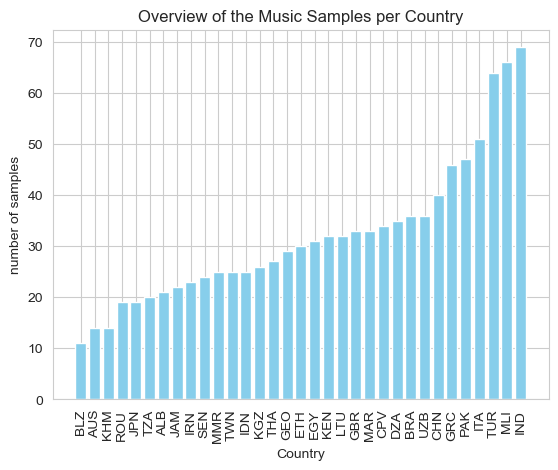

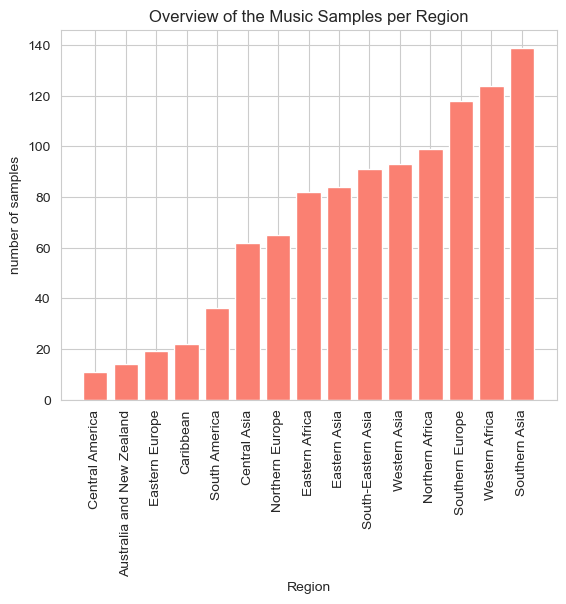

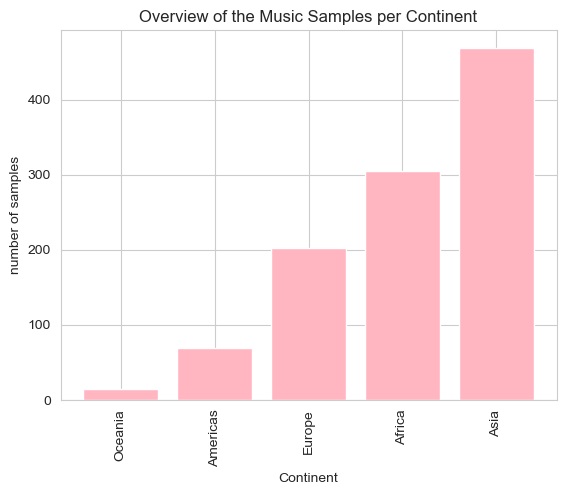

In [215]:
per_country = music_origin_gdf.groupby('iso3').nunique().reset_index().sort_values('Feature1')
plt.bar(per_country["iso3"],per_country["Feature1"], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.show()

per_region = music_origin_gdf.groupby('region').nunique().reset_index().sort_values('Feature1')
plt.bar(per_region["region"],per_region["Feature1"], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

per_continent = music_origin_gdf.groupby('continent').nunique().reset_index().sort_values('Feature1')
plt.bar(per_continent["continent"],per_continent["Feature1"], color = "lightpink")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Continent")
plt.ylabel("number of samples")
plt.xlabel("Continent")
plt.show()

# Have a Look at the 68 Features

Text(0.5, 1.0, 'Boxplot of all Features of the Music Dataset')

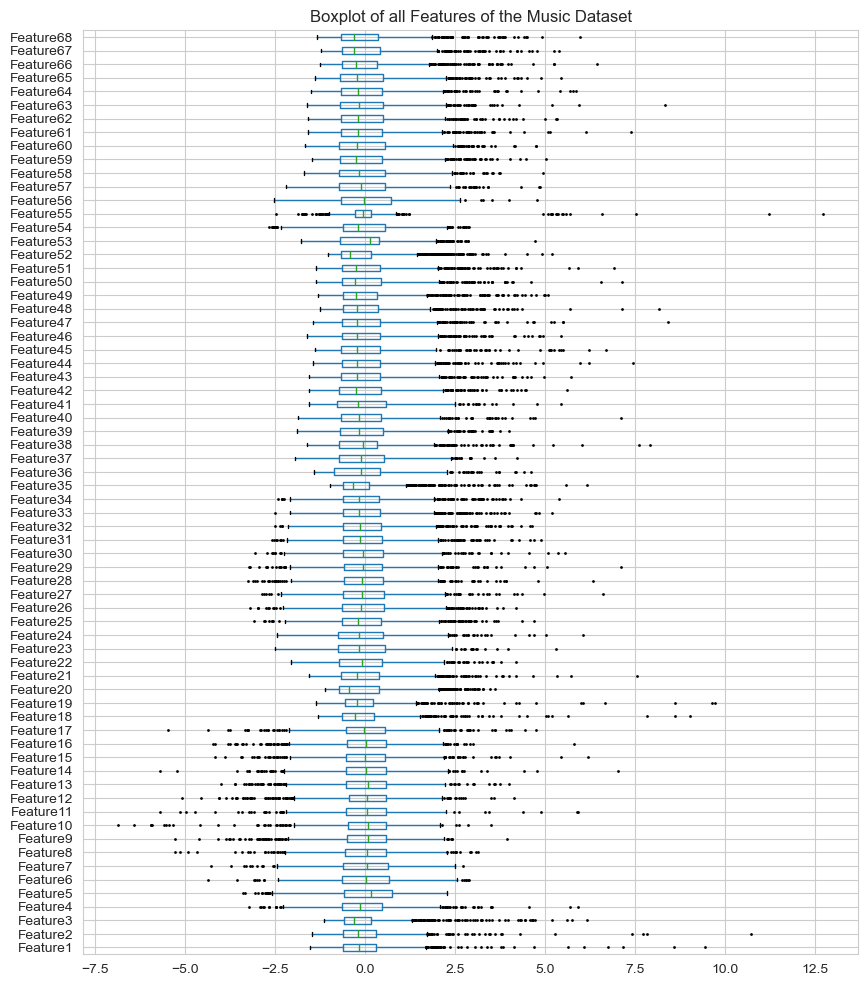

In [216]:
plt.figure(figsize=(10, 12))
music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                        'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                        'french_shor'],axis=1).boxplot(vert=False,
                                                       flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset")

There are alot of features, thus it could be an idea, to make a Principle Component Analysis to reduce the number of features.

# PCA

In [217]:
#make PCA:
scaler = preprocessing.StandardScaler()
music_origin_gdf_scaled = scaler.fit_transform(music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                      'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                      'french_shor'],axis=1))
nums = np.arange(68)
var_ratio = []
for num in nums:
    pca = PCA(n_components=num).fit(music_origin_gdf_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(3, 0.15, '20% cut-off')

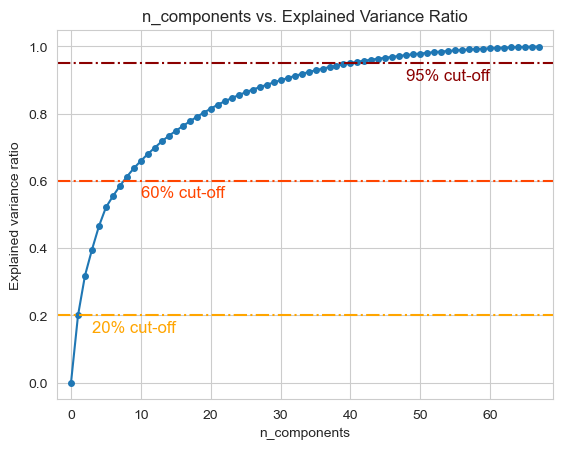

In [218]:
plt.plot(nums,var_ratio,marker='o',markersize = 4)
plt.xlim(-2,69)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='darkred', linestyle='-.')
plt.text(48, 0.9, '95% cut-off', color = 'darkred', fontsize=12)
plt.axhline(y=0.6, color='orangered', linestyle='-.')
plt.text(10, 0.55, '60% cut-off ', color = 'orangered', fontsize=12)
plt.axhline(y=0.2, color='orange', linestyle='-.')
plt.text(3, 0.15, '20% cut-off', color = 'orange', fontsize=12)

Okay, we choose the 95% cut-off beacuse then we have 95% of the variance explained, which is quite good.

Number of components to reach 95% cutoff: 41
Number of components to reach 60% cutoff: 9
Number of components to reach 20% cutoff: 3


C:\Users\claud\AppData\Local\Temp\ipykernel_20656\1742185845.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'iso_3166_1__x', 'geometry_x', 'color_code_x', 'french_shor_x', 'status_x', 'name_x', 'region_x', 'iso3_x', 'Latitude_x', 'continent_x', 'Longitude_x'} in the result is deprecated and will raise a MergeError in a future version.
  music_origin_gdf_pca = music_origin_gdf_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'geometry', 'iso3',


Text(0.5, 1.0, 'Boxplot of all Features of the Music Dataset after PCA')

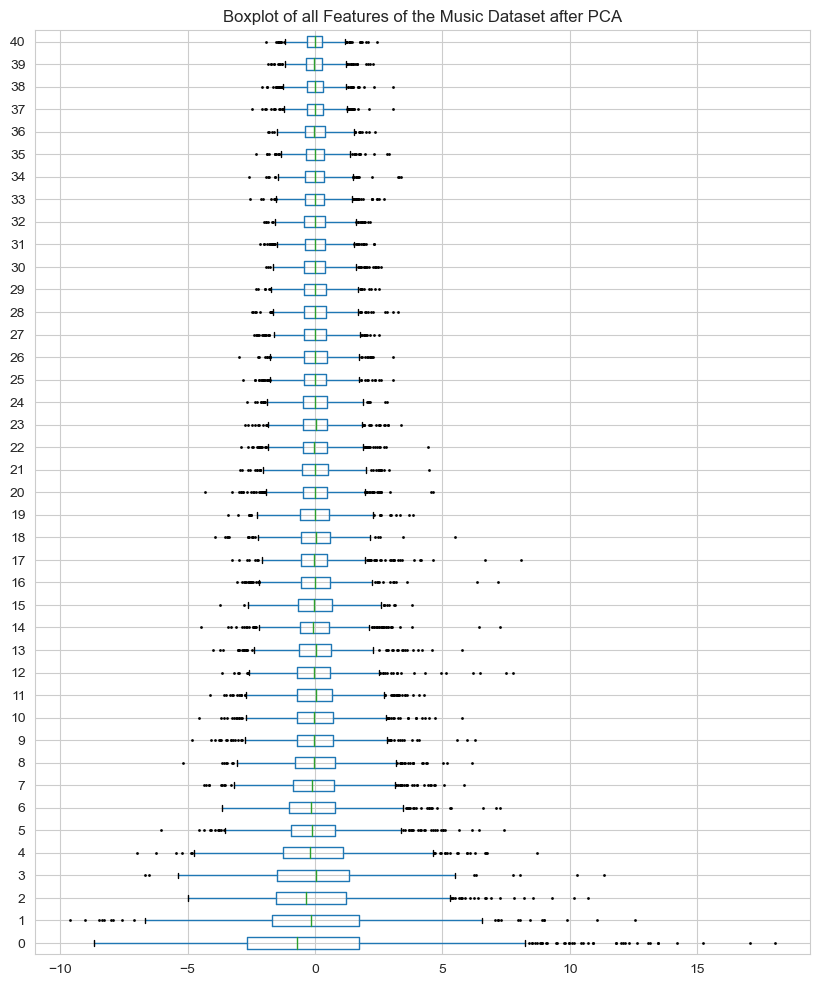

In [223]:
def get_num_components(percent,var_ratio = var_ratio):
    num_components_XX_percent = np.argmax(np.array(var_ratio) >= percent/100) + 1
    #print(f"Number of components to reach {percent}% cutoff: {num_components_XX_percent}")
    return num_components_XX_percent

print(f"Number of components to reach 95% cutoff: {get_num_components(95)}")
print(f"Number of components to reach 60% cutoff: {get_num_components(60)}")
print(f"Number of components to reach 20% cutoff: {get_num_components(20)}")

#make PCA with 95% cutoff
music_origin_pca= pd.DataFrame(PCA(n_components=get_num_components(95)).fit_transform(music_origin_gdf_scaled))
music_origin_gdf_pca = music_origin_gdf_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                          'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                          'french_shor']], left_index=True, right_index=True)


plt.figure(figsize=(10, 12))
music_origin_pca.boxplot(vert=False, flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset after PCA")


# Appendix

In [220]:
from sklearn.model_selection import train_test_split
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import catboost as cb

start_time = datetime.now()



X_train, X_test, y_train, y_test = train_test_split(data3, data2['country'], test_size=0.2)




param_grid = {
    'iterations': [100],
    'depth': [6],
    'learning_rate': [0.1]
}
#define the scorer, in this case we can use the mean squared error:
scorer = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)

}#initialize the model:
rfc = cb.CatBoostClassifier()

#make the GridSearch:

grid_search = GridSearchCV(
    estimator=rfc, #implement the GradienBoostingClassifier
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU,
    refit='mse',
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:

grid_search.fit(X_train,y_train)


NameError: name 'data3' is not defined